In [283]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline, make_pipeline
%matplotlib 
%pylab inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/chrisbyrnes/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['poly', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [284]:
df_golf=pd.read_csv('/Users/chrisbyrnes/Metis/NBM_Regression_Student/df_final.csv')
df_golf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1870 non-null   int64  
 1   RK              1870 non-null   int64  
 2   PLAYER          1870 non-null   object 
 3   AGE             1870 non-null   int64  
 4   EVENTS          1870 non-null   int64  
 5   ROUNDS          1870 non-null   int64  
 6   CUTS MADE       1870 non-null   int64  
 7   TOP 10          1870 non-null   int64  
 8   WINS            1870 non-null   int64  
 9   CUP POINTS      1870 non-null   object 
 10  EARNINGS        1870 non-null   float64
 11  YEAR            1870 non-null   int64  
 12  YDS/DRIVE       1870 non-null   float64
 13  DRIVING ACC.    1870 non-null   float64
 14  DRVE TOTAL      1870 non-null   int64  
 15  GREENS IN REG.  1870 non-null   float64
 16  PUTT AVG.       1870 non-null   float64
 17  SAVE PCT.       1870 non-null   f

In [285]:
df_golf.drop(columns=["Unnamed: 0"],inplace=True)

In [286]:
df_golf.columns = df_golf.columns.str.replace(" ", "_")
df_golf.columns = df_golf.columns.str.replace(".","")
df_golf.columns = df_golf.columns.str.replace("/","_")
df_golf.columns

<ipython-input-286-a48fc9e8b83a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_golf.columns = df_golf.columns.str.replace(".","")


Index(['RK', 'PLAYER', 'AGE', 'EVENTS', 'ROUNDS', 'CUTS_MADE', 'TOP_10',
       'WINS', 'CUP_POINTS', 'EARNINGS', 'YEAR', 'YDS_DRIVE', 'DRIVING_ACC',
       'DRVE_TOTAL', 'GREENS_IN_REG', 'PUTT_AVG', 'SAVE_PCT', 'EAGLES',
       'BIRDIES', 'PARS', 'BOGEYS', 'BIRDIES_RD', 'HOLES_EAGLE'],
      dtype='object')

In [287]:
df_golf.corr()
#TOP_10, CUTS_MADE, ROUNDS, and EVENTS have strong correlation with each other and EARNINGS. WINS also has 
#strong correlation with EARNINGS. Would like to see how much EARNINGS can be predicted without using all of these
#highly correlated data fields. Will need to use one of them and it will be CUTS_MADE.

,RK,AGE,EVENTS,ROUNDS,CUTS_MADE,TOP_10,WINS,EARNINGS,YEAR,YDS_DRIVE,...,DRVE_TOTAL,GREENS_IN_REG,PUTT_AVG,SAVE_PCT,EAGLES,BIRDIES,PARS,BOGEYS,BIRDIES_RD,HOLES_EAGLE
RK,1.000000,0.192538,-0.181261,-0.428593,-0.699179,-0.799244,-0.495344,-0.805591,-0.031091,-0.271535,...,0.214506,-0.376784,0.458830,-0.250580,-0.359653,-0.565291,-0.396406,-0.220282,-0.541590,0.142078
AGE,0.192538,1.000000,-0.000988,-0.092459,-0.128541,-0.145381,-0.119263,-0.194250,-0.516707,-0.436630,...,0.417972,-0.220230,0.257840,-0.040928,-0.103135,-0.197928,-0.050946,-0.017644,-0.345442,-0.011652
EVENTS,-0.181261,-0.000988,1.000000,0.737377,0.478128,0.142777,0.009070,0.066403,-0.297228,-0.142789,...,0.042324,-0.069678,0.002287,0.002982,0.353392,0.631740,0.715387,0.719463,-0.058069,-0.072184
ROUNDS,-0.428593,-0.092459,0.737377,1.000000,0.842160,0.321698,0.104465,0.268517,-0.214350,-0.040971,...,0.008534,0.130504,-0.159342,0.089268,0.527002,0.938034,0.987142,0.886495,0.126629,-0.117644
CUTS_MADE,-0.699179,-0.128541,0.478128,0.842160,1.000000,0.569312,0.252291,0.545530,-0.088916,0.115164,...,-0.133542,0.323305,-0.342375,0.214875,0.507101,0.887111,0.828352,0.635478,0.377377,-0.121853
TOP_10,-0.799244,-0.145381,0.142777,0.321698,0.569312,1.000000,0.527339,0.869958,-0.032087,0.245739,...,-0.182713,0.305638,-0.449513,0.245307,0.351562,0.495568,0.302569,0.108060,0.557419,-0.165531
WINS,-0.495344,-0.119263,0.009070,0.104465,0.252291,0.527339,1.000000,0.768369,-0.001487,0.201208,...,-0.122442,0.145435,-0.282981,0.120508,0.247885,0.225474,0.081057,0.002605,0.360187,-0.121408
EARNINGS,-0.805591,-0.194250,0.066403,0.268517,0.545530,0.869958,0.768369,1.000000,0.067316,0.307370,...,-0.237300,0.332010,-0.455278,0.251056,0.347084,0.441703,0.226466,0.048084,0.578729,-0.160081
YEAR,-0.031091,-0.516707,-0.297228,-0.214350,-0.088916,-0.032087,-0.001487,0.067316,1.000000,0.314442,...,-0.473592,0.349756,-0.271800,0.078076,-0.181261,-0.126137,-0.271915,-0.366839,0.307628,0.182285
YDS_DRIVE,-0.271535,-0.436630,-0.142789,-0.040971,0.115164,0.245739,0.201208,0.307370,0.314442,1.000000,...,-0.673701,0.313684,-0.100027,-0.129040,0.250906,0.134880,-0.099731,-0.066721,0.476439,-0.176784


In [288]:
#STATSMODELS, getting a general sense of results. Age appears to not be a significant predictor of earnings.
lm1 = smf.ols('EARNINGS ~ AGE + YEAR + CUTS_MADE + DRIVING_ACC + YDS_DRIVE + GREENS_IN_REG + PUTT_AVG + SAVE_PCT', data=df_golf)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EARNINGS   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     219.8
Date:                Thu, 15 Apr 2021   Prob (F-statistic):          2.37e-262
Time:                        17:12:40   Log-Likelihood:                -28493.
No. Observations:                1870   AIC:                         5.700e+04
Df Residuals:                    1861   BIC:                         5.705e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.393e+08   1.95e+07      7.145      0.000    1.01e+08    1.77e+08
AGE            -111.9689   3960.863     -0.028      0.977   -7880.169    7656.232
YEAR          -6.555e+04   9466.744     -6.925      0.000   -8.41e+04    -4.7e+04
CUTS_MADE      8.569e+04   6453.542     13.278      0.000     7.3e+04    9.83e+04
DRIVING_ACC    4.389e+04   6580.334      6.669      0.000     3.1e+04    5.68e+04
YDS_DRIVE      5.411e+04   3911.469     13.833      0.000    4.64e+04    6.18e+04
GREENS_IN_REG      6e+04   9851.677      6.091      0.000    4.07e+04    7.93e+04
PUTT_AVG      -1.744e+07   1.06e+06    -16.465      0.000   -1.95e+07   -1.54e+07
SAVE_PCT       3.132e+04   4059.334      7.716      0.000    2.34e+04    3.93e+04
==============================================================================
Omnibus:                      819.910   Durbin-Watson:                   0.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5877.830
Skew:                           1.910   Prob(JB):                         0.00
Kurtosis:                      10.800   Cond. No.                     1.71e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [289]:
#SKLEARN broad view, as expected same results
X = df_golf[['AGE','YEAR','CUTS_MADE','YDS_DRIVE','DRIVING_ACC', 'GREENS_IN_REG', 'PUTT_AVG', 'SAVE_PCT']]
y = df_golf['EARNINGS']

lm = LinearRegression() # construct LinearRegression model object
lm.fit(X, y) #fit model to our choice of features

LinearRegression()

In [290]:
print(lm.intercept_)
print(lm.coef_)
print(lm.score(X,y))

139272524.99016112
[-1.11968854e+02 -6.55526464e+04  8.56882363e+04  5.41083529e+04
  4.38872238e+04  6.00044021e+04 -1.74359849e+07  3.13214380e+04]
0.48583133069453477


In [291]:
#generate train, validate, and test data groups
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=5)

In [292]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
print(lr_model.intercept_)
print(lr_model.coef_)
print(lr_model.score(X_train,y_train))

152195678.53913376
[-1.59840401e+03 -7.23805138e+04  7.52066255e+04  6.39098437e+04
  5.37059084e+04  5.95945270e+04 -1.88868425e+07  3.49485878e+04]
0.49938462902110403


In [293]:
#score fit on validation data
val_score = lr_model.score(X_val, y_val)

In [294]:
print(val_score) # R^2 on train slightly larger than validate

0.44604972735611215


In [295]:
test_score = lr_model.score(X_test, y_test)
print(test_score)

0.45607139587686785


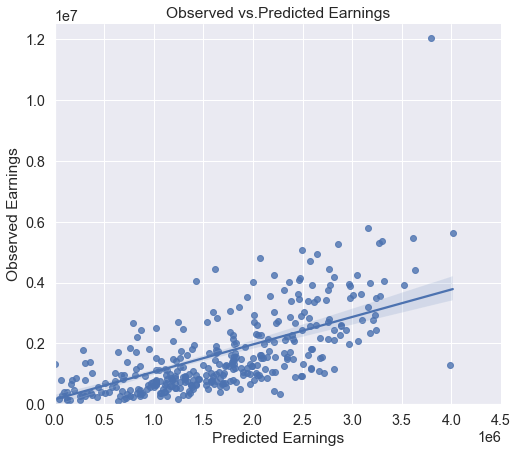

In [364]:
preds = lr_model.predict(X_test)
plt.figure(figsize=(8, 7))
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
plt.title("Observed vs.Predicted Earnings")
plt.xlabel('Predicted Earnings')
sns.regplot(x=preds,y=y_test)
plt.xlim([0, 4500000])
plt.ylim([0, 12500000])
plt.ylabel('Observed Earnings')
sns.despine()
plt.savefig("observed_vs_predicted_test.png")

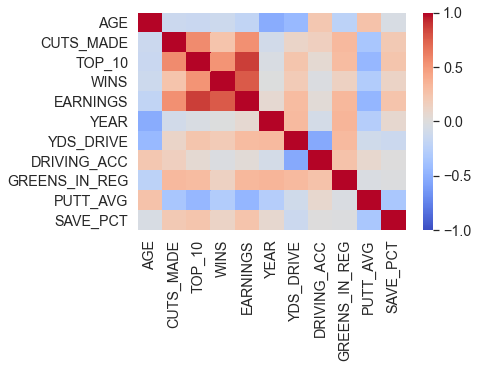

<Figure size 432x288 with 0 Axes>

In [282]:
#had run this earlier but need to re-run get visual again for presentation
#df_golf.drop(["RK","EAGLES","BIRDIES","PARS","BOGEYS","BIRDIES_RD","HOLES_EAGLE"],axis=1,inplace=True)
#df_golf.drop(["DRVE_TOTAL"],axis=1,inplace=True)
#df_golf.drop(["ROUNDS","EVENTS"],axis=1,inplace=True)
sns.heatmap(df_golf.corr(), cmap="coolwarm",vmin=-1, vmax=1)
plt.show()
plt.savefig("correlation.png")

In [307]:
#standard scaling features for Lasso and Ridge regression.
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_vl = std.transform(X_val.values)
X_te = std.transform(X_test.values)

(array([ 12.,  52., 138., 207., 288., 225., 122.,  48.,  26.,   4.]),
 array([-2.76908378, -2.15961072, -1.55013767, -0.94066461, -0.33119156,
         0.2782815 ,  0.88775456,  1.49722761,  2.10670067,  2.71617372,
         3.32564678]),
 <BarContainer object of 10 artists>)

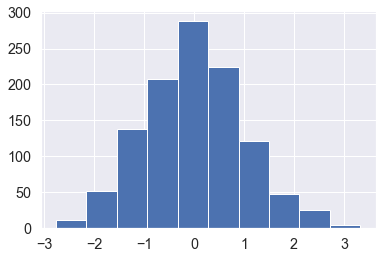

In [309]:
plt.hist(X_tr[:,3])

In [299]:
lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_tr,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('AGE', -0.0),
 ('YEAR', -206394.49925538962),
 ('CUTS_MADE', 344925.8745469456),
 ('YDS_DRIVE', 554588.0937264551),
 ('DRIVING_ACC', 240102.17516353136),
 ('GREENS_IN_REG', 187996.73836463466),
 ('PUTT_AVG', -499272.9194558564),
 ('SAVE_PCT', 206950.23213802502)]

In [300]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(cv=5)

In [301]:
train_set_pred = lasso_model.predict(X_tr)
r2_score(y_train, train_set_pred)

0.49920993230330046

In [302]:
lasso_model.alpha_

5247.928713932862

In [303]:
list(zip(X_train.columns, lasso_model.coef_))

[('AGE', -2374.5903021618665),
 ('YEAR', -220029.73004871554),
 ('CUTS_MADE', 340665.22015824966),
 ('YDS_DRIVE', 569488.8134654093),
 ('DRIVING_ACC', 253294.9712473053),
 ('GREENS_IN_REG', 190923.5447293592),
 ('PUTT_AVG', -505635.81685879536),
 ('SAVE_PCT', 213574.00995497336)]

In [311]:
val_set_pred = lasso_model.predict(X_vl)
r2_score(y_val, val_set_pred)

0.44911755966768685

In [313]:
test_set_pred = lasso_model.predict(X_te)
r2_score(y_test, test_set_pred)

0.45786786573130667

In [319]:
lr_model_ridge = Ridge(alpha = 1)
lr_model_ridge.fit(X_tr, y_train)
lr_model_ridge.score(X_tr,y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('AGE', -12077.606844431722),
 ('YEAR', -237501.71211051344),
 ('CUTS_MADE', 335216.05977854907),
 ('YDS_DRIVE', 582637.7042048816),
 ('DRIVING_ACC', 267197.0213362867),
 ('GREENS_IN_REG', 194788.65784345943),
 ('PUTT_AVG', -511652.07801550836),
 ('SAVE_PCT', 220720.2461519473)]

In [320]:
lr_model_ridge.score(X_tr,y_train)

0.49938397248991395

In [317]:
rval_set_pred = lr_model_ridge.predict(X_vl)
r2_score(y_val,rval_set_pred)

0.4462491072512593

In [322]:
rtest_set_pred = lr_model_ridge.predict(X_te)
r2_score(y_test,rtest_set_pred)

0.4562556695475629

In [208]:
#still not much improvements on R^2 from original linear regression. Let's try a polynomial of degree 2

In [326]:
est = make_pipeline(PolynomialFeatures(2), LinearRegression())
est.fit(X_tr,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [328]:
poly2_train_set_pred = est.predict(X_tr)
r2_score(y_train, poly2_train_set_pred)

0.6601102257253233

In [329]:
poly2_val_set_pred = est.predict(X_vl)
r2_score(y_val, poly2_val_set_pred)

0.5644107351482295

In [330]:
poly2_test_set_pred = est.predict(X_te)
r2_score(y_test, poly2_test_set_pred)

0.5506742108440162

<AxesSubplot:ylabel='EARNINGS'>

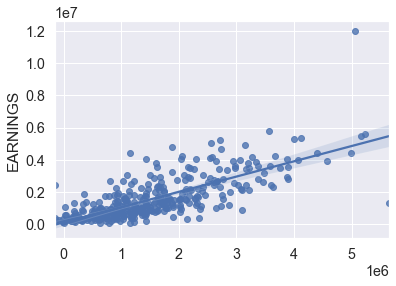

In [331]:
sns.regplot(x=poly2_test_set_pred,y=y_test)

In [336]:
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x6^2',
 'x6 x7',
 'x7^2']

In [337]:
#R^2 has increased nicely,however regression formula is overly complex and the gap between train data and validate 
#implies overfitting. Hopefully Lasso can simply and fix some of the overfitting.
lr_poly.coef_

array([ 4.76712583e+00, -5.20250653e+06,  3.46854895e+05, -1.80175341e+07,
        7.38639754e+06,  6.77770455e+06,  3.59978539e+07, -5.10788084e+09,
        2.18131550e+06, -2.83177472e+02,  2.60926767e+03,  3.07606744e+02,
       -1.53011319e+02,  1.28290004e+03,  1.22357778e+03, -5.90094627e+04,
       -8.69816291e+02, -6.53580366e+02,  8.66574442e+03, -3.35995649e+03,
       -3.73969802e+03, -1.67390229e+04,  2.45149392e+06, -7.60976639e+02,
        1.27535163e+03,  7.52161523e+02,  1.47002003e+03, -5.25045165e+03,
        3.15419316e+05,  1.55489849e+03,  1.46394341e+03,  3.42352127e+03,
        5.30103909e+03, -1.15153202e+06,  1.28222253e+03,  1.55190574e+03,
        6.20507844e+03, -5.39371480e+05,  1.99026200e+03,  4.79792139e+03,
       -2.70365485e+06,  1.12942108e+03,  2.05948188e+08, -7.14836397e+05,
        9.29991506e+02])

In [352]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
X_poly_scaled = scaler.fit_transform(X_poly)
lasso = LassoCV(max_iter=100000)
lasso.fit(X_poly_scaled,y_train)

#Apply the same polynomial and scaling transformations to test set, then score
X_test_poly = poly.transform(X_test)
X_test_poly_scaled = scaler.transform(X_test_poly)
lasso.score(X_test_poly_scaled, y_test)

0.5402881110447216

In [342]:
list(zip(poly.get_feature_names(['AGE','YEAR','CUTS_MADE','YDS_DRIVE','DRIVING_ACC', 'GREENS_IN_REG', 'PUTT_AVG', 'SAVE_PCT']),lasso.coef_))

#list(zip(X_train.columns, lr_model_ridge.coef_))

[('1', 0.0),
 ('AGE', -24118.095191504075),
 ('YEAR', -0.0),
 ('CUTS_MADE', 687510.1028245967),
 ('YDS_DRIVE', 1257419.4955835303),
 ('DRIVING_ACC', -0.0),
 ('GREENS_IN_REG', 71551.27432535241),
 ('PUTT_AVG', -488597.3119546865),
 ('SAVE_PCT', 0.0),
 ('AGE^2', -228981.97203470027),
 ('AGE YEAR', -0.0),
 ('AGE CUTS_MADE', -172558.07214222653),
 ('AGE YDS_DRIVE', -138558.6363120987),
 ('AGE DRIVING_ACC', -3166.337387274875),
 ('AGE GREENS_IN_REG', 730607.3889110619),
 ('AGE PUTT_AVG', 0.0),
 ('AGE SAVE_PCT', -291693.6685416527),
 ('YEAR^2', -180536.81168716977),
 ('YEAR CUTS_MADE', 0.0),
 ('YEAR YDS_DRIVE', 0.0),
 ('YEAR DRIVING_ACC', -0.0),
 ('YEAR GREENS_IN_REG', 0.0),
 ('YEAR PUTT_AVG', -280017.1659124598),
 ('YEAR SAVE_PCT', 0.0),
 ('CUTS_MADE^2', 127740.38483552002),
 ('CUTS_MADE YDS_DRIVE', 2598009.8191340812),
 ('CUTS_MADE DRIVING_ACC', 235730.4159502201),
 ('CUTS_MADE GREENS_IN_REG', 1607676.0503334806),
 ('CUTS_MADE PUTT_AVG', -5167791.886922713),
 ('CUTS_MADE SAVE_PCT', 799984.

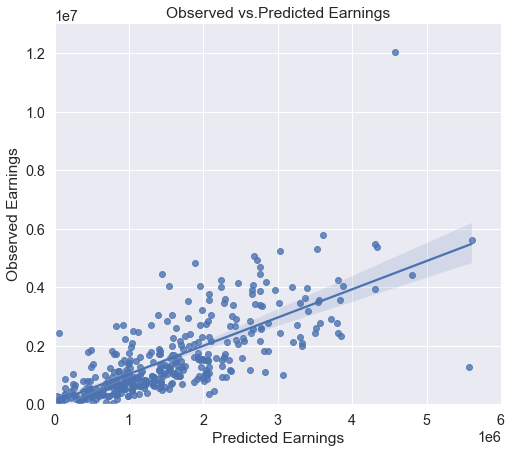

In [365]:
preds = lasso.predict(X_test_poly_scaled) 
plt.figure(figsize=(8, 7))
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
plt.title("Observed vs.Predicted Earnings")
plt.xlabel('Predicted Earnings')
sns.regplot(x=preds,y=y_test)
plt.xlim([0, 6000000])
plt.ylim([0, 13000000])
plt.ylabel('Observed Earnings')
sns.despine()
plt.savefig("observed_vs_predicted_test_final.png")

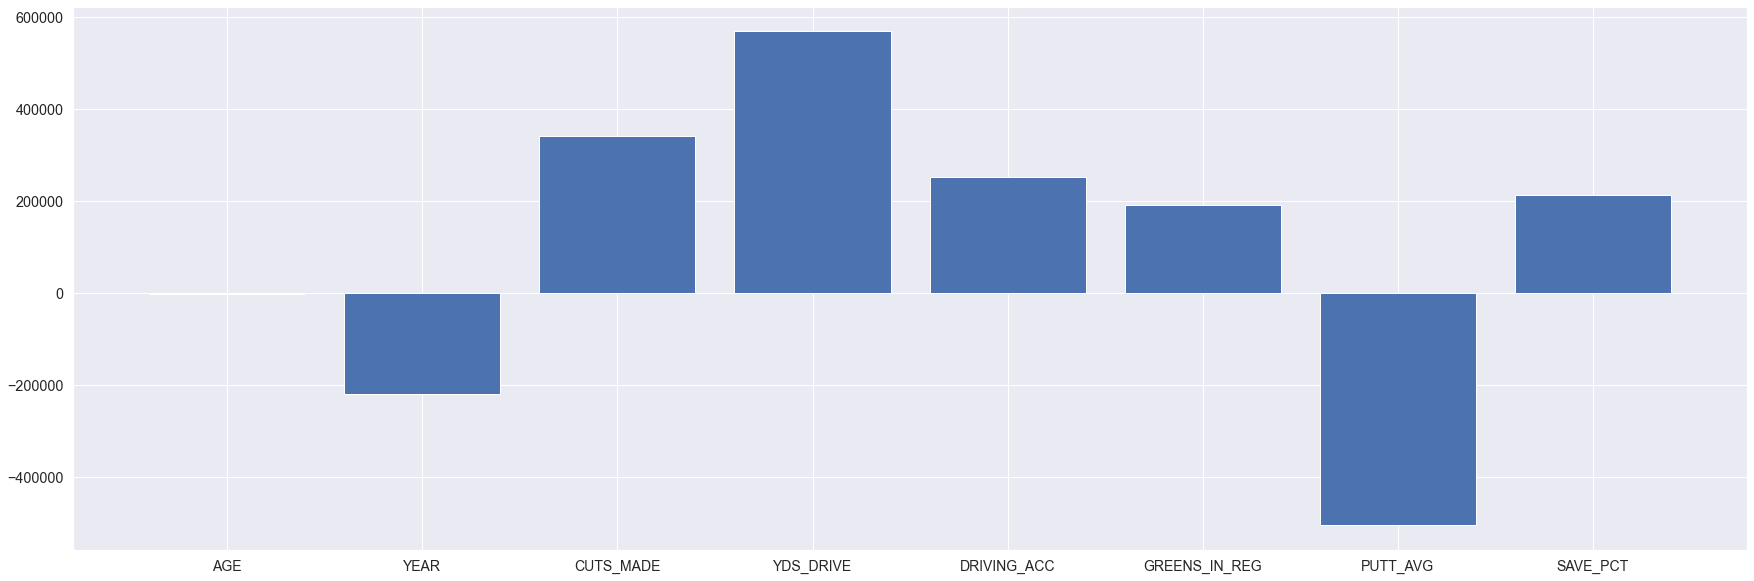

In [360]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize=14)
plt.bar(X_train.columns, lasso_model.coef_)
plt.savefig("Feature_Plot_Lasso.png")